In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pyreadr

In [33]:
data = pyreadr.read_r("gss_16.rda")

In [34]:
df = data["gss16"]

In [35]:
df.head()

,harass5,emailmin,emailhr,educ,polviews,advfront,snapchat,instagrm,wrkstat
0,NaN,0.0,12.0,16.0,Moderate,Strongly agree,NaN,NaN,Working fulltime
1,NaN,30.0,0.0,12.0,Liberal,Disagree,No,No,Working fulltime
2,No,NaN,NaN,16.0,Conservative,NaN,No,No,Retired
3,NaN,10.0,0.0,12.0,Moderate,Disagree,NaN,NaN,Working parttime
4,No,NaN,NaN,18.0,Slightly liberal,NaN,Yes,Yes,Working parttime


In [36]:
df.shape

(2867, 9)

In [6]:
categorical_columns = ['harass5', 'polviews', 'advfront', 'snapchat', 'instagrm', 'wrkstat']
# Tính tỷ lệ na cho mỗi biến
null_percentage = df.isna().mean() * 100

# Hiển thị kết quả
print(null_percentage)

harass5     48.761772
emailmin    42.483432
emailhr     42.483432
educ         0.313917
polviews     3.871643
advfront    51.691664
snapchat    52.145099
instagrm    52.145099
wrkstat      0.104639
dtype: float64


# 1/ Xử lý dữ liệu

In [37]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

# Bước 1: Loại bỏ các hàng có giá trị null trong 'educ' hoặc 'wrkstat'
columns_to_check = ['educ', 'wrkstat']
df.dropna(subset=columns_to_check, inplace=True)

# Bước 2: Tính emailtotal (tổng thời gian email theo phút)
df['emailtotal'] = np.where(df['emailhr'].isna() | df['emailmin'].isna(), np.nan, df['emailhr'] * 60 + df['emailmin'])
df = df.drop(['emailhr', 'emailmin'], axis=1)

# Bước 3: Ép kiểu cho 'educ'
df['educ'] = df['educ'].astype(np.int16)

# Bước 4: Tạo value_to_index cho từng cột
value_to_index = {}

for col in df.columns.tolist():
    if col == 'emailtotal':
        continue
    try:
        unique_set = np.unique(df[col].to_numpy()).tolist()
        unique_set = [x for x in unique_set if not math.isnan(x)]
        unique_set.sort()
        value_to_index[col] = dict(zip(unique_set, unique_set))
    except:
        unique_set = list(set(df[col].tolist()))
        chosens = []
        for i in unique_set:
            if isinstance(i, float) and math.isnan(i):
                continue
            chosens.append(i)
        unique_set = sorted(chosens)

        if col == "advfront":
            value_to_index[col] = {
                'Strongly disagree': 1, 'Disagree': 2, 'Dont know': 3, 'Agree': 4, 'Strongly agree': 5
            }
        elif col == "polviews":
            value_to_index[col] = {
                'Extrmly conservative': 1, 'Conservative': 2, 'Slghtly conservative': 3, 'Moderate': 4,
                'Slightly liberal': 5, 'Liberal': 6, 'Extremely liberal': 7
            }
        elif col in ["educ", "wrkstat"]:
            value_to_index[col] = dict(zip(unique_set, range(len(unique_set))))
        else:
            value_to_index[col] = dict(zip(unique_set, range(1, len(unique_set) + 1)))

# Bước 5: Mapping giá trị văn bản sang số
for col in df.columns.tolist():
    if col == 'emailtotal' or col == "wrkstat":
        continue
    df[col] = df[col].map(value_to_index[col])

# Bước 6: Xử lý missing values cho categorical
categorical_columns = ['harass5', 'polviews', 'advfront', 'snapchat', 'instagrm', 'wrkstat']
df[categorical_columns] = df[categorical_columns].fillna(0)
df['educ'] = df['educ'].fillna(21)

# Bước 7: Ép kiểu int16 cho các cột categorical
casted_columns = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm']
for col in casted_columns:
    df[col] = df[col].astype(np.int16)

# Bước 8: One-hot encoding
categorical_columns = ['harass5', 'snapchat', 'instagrm', 'polviews', 'advfront', 'educ']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)


## 2.Mô hình Multinomial logistic regression

## 2.1. Mô hình được huấn luyện trên tập dữ liệu chỉ bao gồm các quan sát có cột emailtotal không phải giá trị null.

In [38]:
df_encoded_notnull = df_encoded[df_encoded['emailtotal'].notna()].copy()
df_encoded_notnull['emailtotal'] = df_encoded_notnull['emailtotal'].astype(np.int16)

scaler = StandardScaler()
df_encoded_notnull[['emailtotal']] = scaler.fit_transform(df_encoded_notnull[['emailtotal']])

features_notnull = df_encoded_notnull.columns.tolist()
features_notnull.remove('wrkstat')

x = df_encoded_notnull.drop('wrkstat', axis=1).to_numpy()
y = df_encoded_notnull['wrkstat'].to_numpy()

### a. Không sử dụng PCA

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(x_train, y_train)

# Dự đoán
y_pred = model.predict(x_test)


/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [59]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5121212121212121

Classification Report:
                   precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        30
           Other       0.00      0.00      0.00         6
         Retired       0.35      0.12      0.18        57
          School       0.00      0.00      0.00        10
Temp not working       0.00      0.00      0.00         7
Unempl, laid off       0.00      0.00      0.00        13
Working fulltime       0.52      0.95      0.68       167
Working parttime       0.50      0.07      0.13        40

        accuracy                           0.51       330
       macro avg       0.17      0.14      0.12       330
    weighted avg       0.39      0.51      0.39       330



/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: 

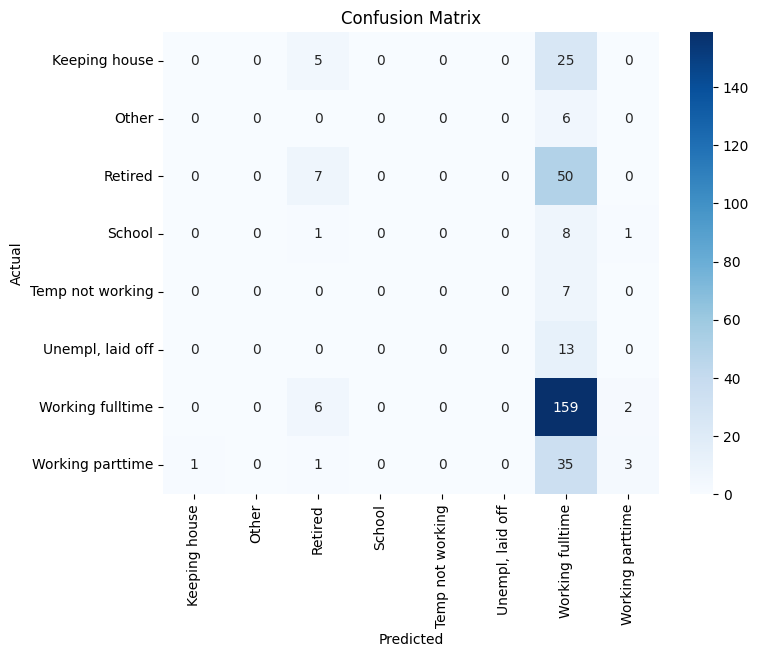

In [21]:
from sklearn.metrics import confusion_matrix
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [60]:
pseudo_label = model.classes_
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: 'Keeping house',
 1: 'Other',
 2: 'Retired',
 3: 'School',
 4: 'Temp not working',
 5: 'Unempl, laid off',
 6: 'Working fulltime',
 7: 'Working parttime'}

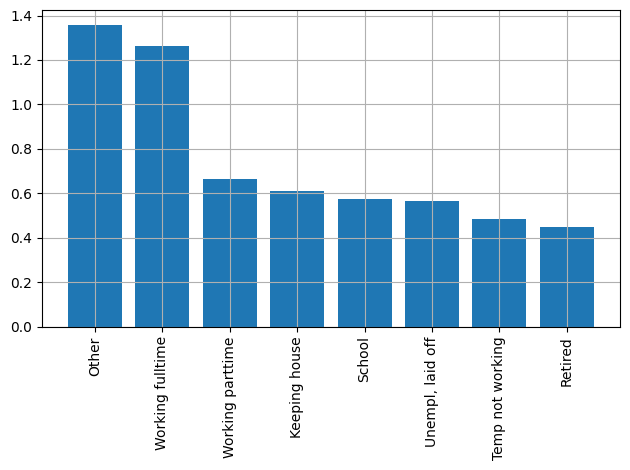

In [61]:
# Sắp xếp theo giá trị tuyệt đối của hệ số intercept, từ lớn đến nhỏ
sorted_indices = np.argsort(np.abs(model.intercept_))[::-1]

# Chuyển chỉ số sang tên lớp (pseudo-label)
sorted_labels = [index_to_pseudo_label[i] for i in sorted_indices]

# Lấy giá trị intercept tương ứng và làm tròn
sorted_values = np.round(model.intercept_[sorted_indices], 3)

# Tạo dictionary tên lớp và giá trị tương ứng
importance_intercept = dict(zip(sorted_labels, sorted_values))

# Vẽ biểu đồ
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid(True)
plt.title("")
plt.tight_layout()
plt.show()


### b. Sử dụng thuật toán PCA

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

print(f"Số chiều sau PCA: {x_pca.shape[1]}")

Số chiều sau PCA: 2


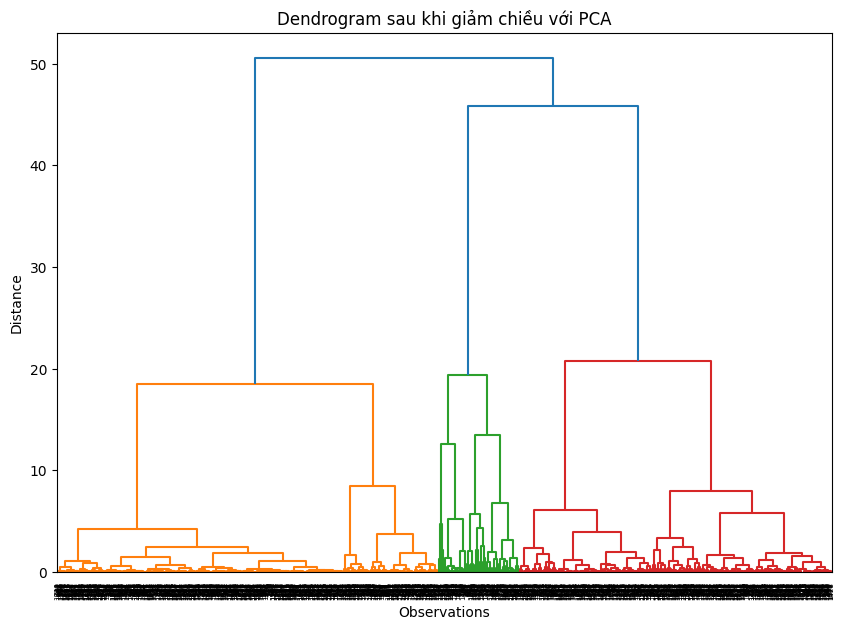

In [66]:

# Tính toán ma trận khoảng cách dựa trên dữ liệu đã qua PCA
distance_matrix = sch.distance.pdist(x_pca, metric='euclidean')

# Tạo mô hình phân cụm thứ bậc sử dụng phương pháp liên kết Ward
linked = sch.linkage(distance_matrix, method='ward')

# Vẽ dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linked)
plt.title('Dendrogram sau khi giảm chiều với PCA')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Sử dụng solver phù hợp cho đa lớp: 'lbfgs'
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(x_train, y_train)

# Dự đoán
y_pred = model.predict(x_test)


/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [69]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5060606060606061

Classification Report:
                   precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        30
           Other       0.00      0.00      0.00         6
         Retired       0.00      0.00      0.00        57
          School       0.00      0.00      0.00        10
Temp not working       0.00      0.00      0.00         7
Unempl, laid off       0.00      0.00      0.00        13
Working fulltime       0.51      1.00      0.67       167
Working parttime       0.00      0.00      0.00        40

        accuracy                           0.51       330
       macro avg       0.06      0.12      0.08       330
    weighted avg       0.26      0.51      0.34       330



/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: 

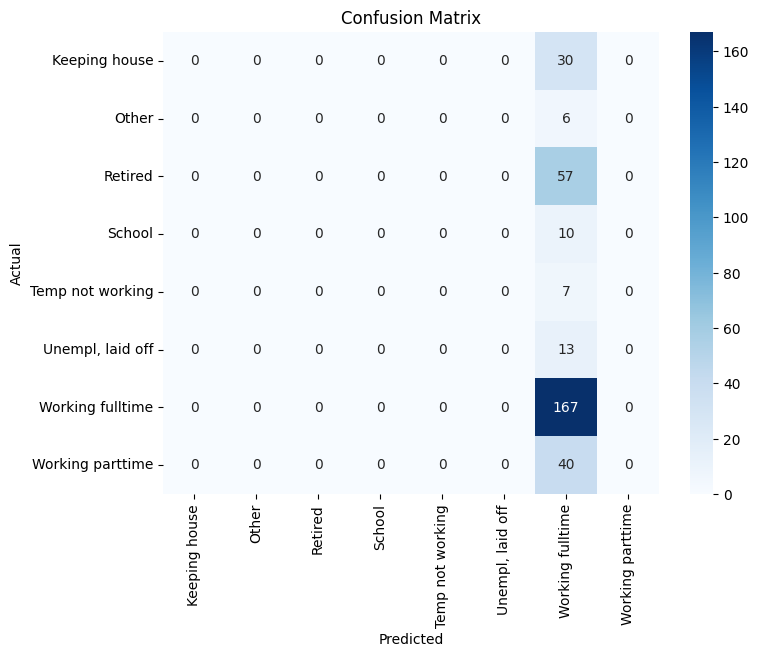

In [70]:
from sklearn.metrics import confusion_matrix
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [71]:
pseudo_label = model.classes_
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: 'Keeping house',
 1: 'Other',
 2: 'Retired',
 3: 'School',
 4: 'Temp not working',
 5: 'Unempl, laid off',
 6: 'Working fulltime',
 7: 'Working parttime'}

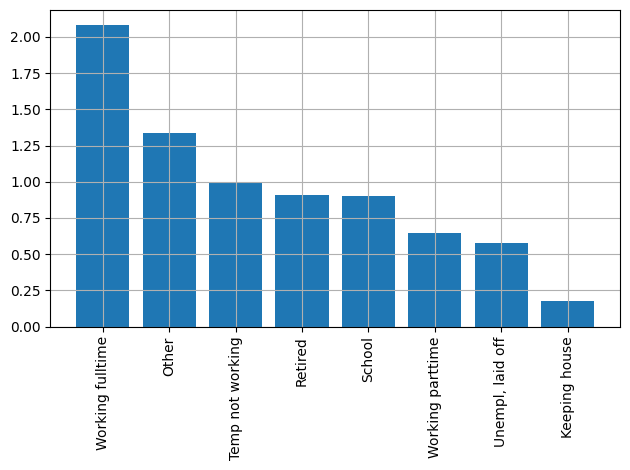

In [72]:
# Sắp xếp theo giá trị tuyệt đối của hệ số intercept, từ lớn đến nhỏ
sorted_indices = np.argsort(np.abs(model.intercept_))[::-1]

# Chuyển chỉ số sang tên lớp (pseudo-label)
sorted_labels = [index_to_pseudo_label[i] for i in sorted_indices]

# Lấy giá trị intercept tương ứng và làm tròn
sorted_values = np.round(model.intercept_[sorted_indices], 3)

# Tạo dictionary tên lớp và giá trị tương ứng
importance_intercept = dict(zip(sorted_labels, sorted_values))

# Vẽ biểu đồ
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid(True)
plt.title("")
plt.tight_layout()
plt.show()


## 2.2. Mô hình được huấn luyện trên tập dữ liệu chỉ bao gồm các quan sát có cột emailtotal là null.

In [41]:
df_encoded.shape

(2858, 47)

In [39]:
df_encoded_null = df_encoded[df_encoded['emailtotal'].isna()].copy()
df_encoded_null.drop(['emailtotal'], axis=1, inplace=True)

features_null = df_encoded_null.columns.tolist()
features_null.remove('wrkstat')

x_null = df_encoded_null.drop('wrkstat', axis=1).to_numpy()
y_null = df_encoded_null['wrkstat'].to_numpy()

In [40]:
df_encoded_null.shape

(1210, 46)

### a. Không sử dụng PCA

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x_null, y_null, test_size=0.2, random_state=42, stratify=y_null)

In [74]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(x_train, y_train)

# Dự đoán
y_pred = model.predict(x_test)

/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [75]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4793388429752066

Classification Report:
                   precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        27
           Other       0.00      0.00      0.00        11
         Retired       0.44      0.64      0.52        58
          School       0.00      0.00      0.00         5
Temp not working       0.00      0.00      0.00         4
Unempl, laid off       0.00      0.00      0.00        11
Working fulltime       0.51      0.81      0.63        97
Working parttime       0.00      0.00      0.00        29

        accuracy                           0.48       242
       macro avg       0.12      0.18      0.14       242
    weighted avg       0.31      0.48      0.38       242



/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: 

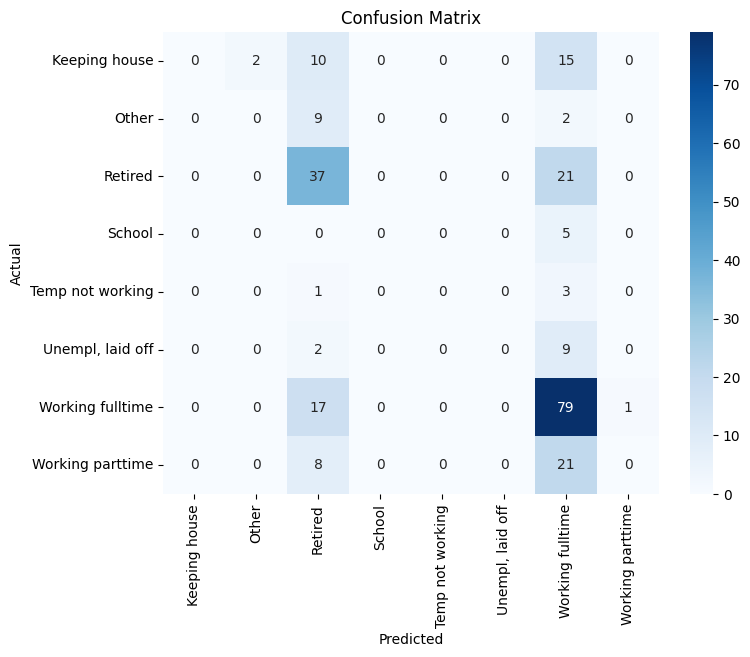

In [48]:
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [76]:
pseudo_label = model.classes_
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: 'Keeping house',
 1: 'Other',
 2: 'Retired',
 3: 'School',
 4: 'Temp not working',
 5: 'Unempl, laid off',
 6: 'Working fulltime',
 7: 'Working parttime'}

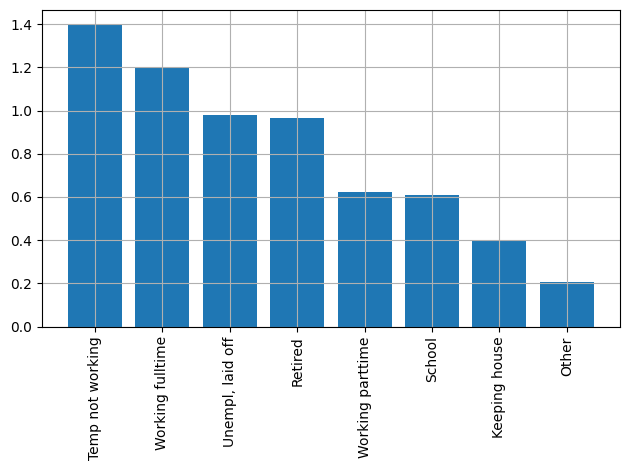

In [77]:
# Sắp xếp theo giá trị tuyệt đối của hệ số intercept, từ lớn đến nhỏ
sorted_indices = np.argsort(np.abs(model.intercept_))[::-1]

# Chuyển chỉ số sang tên lớp (pseudo-label)
sorted_labels = [index_to_pseudo_label[i] for i in sorted_indices]

# Lấy giá trị intercept tương ứng và làm tròn
sorted_values = np.round(model.intercept_[sorted_indices], 3)

# Tạo dictionary tên lớp và giá trị tương ứng
importance_intercept = dict(zip(sorted_labels, sorted_values))

# Vẽ biểu đồ
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid(True)
plt.title("")
plt.tight_layout()
plt.show()


### b. Sử dụng thuật toán PCA

In [78]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_null)

print(f"Số chiều sau PCA: {x_pca.shape[1]}")

Số chiều sau PCA: 2


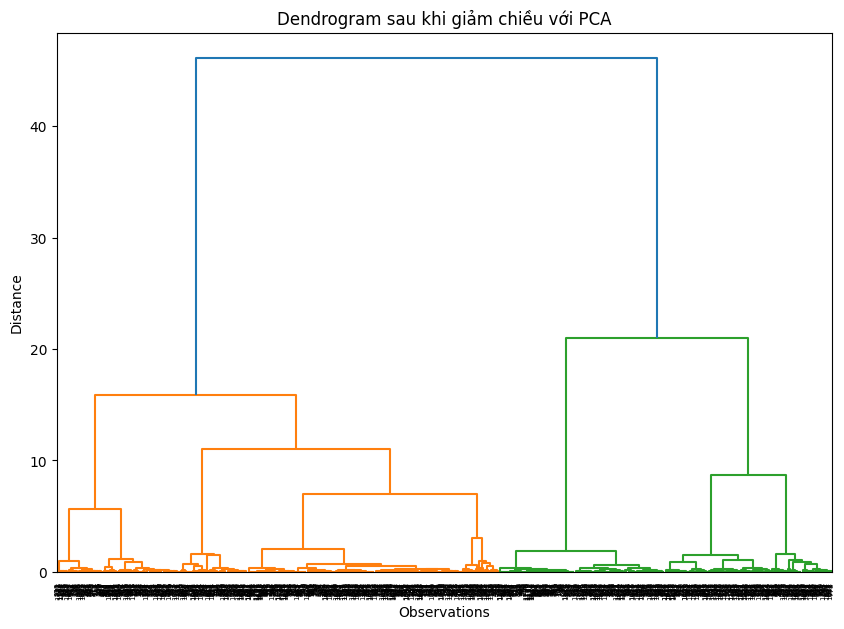

In [79]:

# Tính toán ma trận khoảng cách dựa trên dữ liệu đã qua PCA
distance_matrix = sch.distance.pdist(x_pca, metric='euclidean')

# Tạo mô hình phân cụm thứ bậc sử dụng phương pháp liên kết Ward
linked = sch.linkage(distance_matrix, method='ward')

# Vẽ dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linked)
plt.title('Dendrogram sau khi giảm chiều với PCA')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_null, test_size=0.2, random_state=42, stratify=y_null)

In [81]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(x_train, y_train)

# Dự đoán
y_pred = model.predict(x_test)

/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [82]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4090909090909091

Classification Report:
                   precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        27
           Other       0.00      0.00      0.00        11
         Retired       0.33      0.43      0.38        58
          School       0.00      0.00      0.00         5
Temp not working       0.00      0.00      0.00         4
Unempl, laid off       0.00      0.00      0.00        11
Working fulltime       0.44      0.76      0.56        97
Working parttime       0.00      0.00      0.00        29

        accuracy                           0.41       242
       macro avg       0.10      0.15      0.12       242
    weighted avg       0.26      0.41      0.31       242



/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dongnguyen/Documents/QH2021/Các phương pháp thống kê hiện đại/FinalProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: 

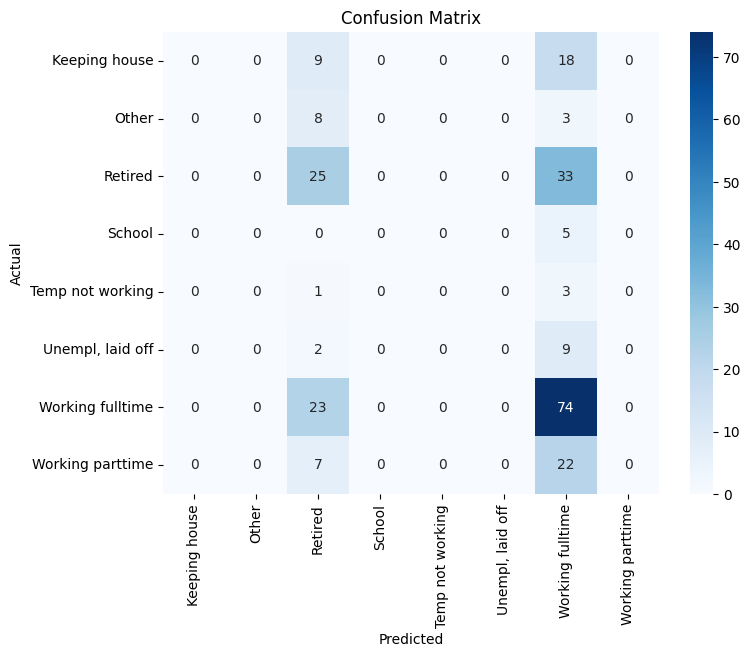

In [56]:
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [83]:
pseudo_label = model.classes_
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: 'Keeping house',
 1: 'Other',
 2: 'Retired',
 3: 'School',
 4: 'Temp not working',
 5: 'Unempl, laid off',
 6: 'Working fulltime',
 7: 'Working parttime'}

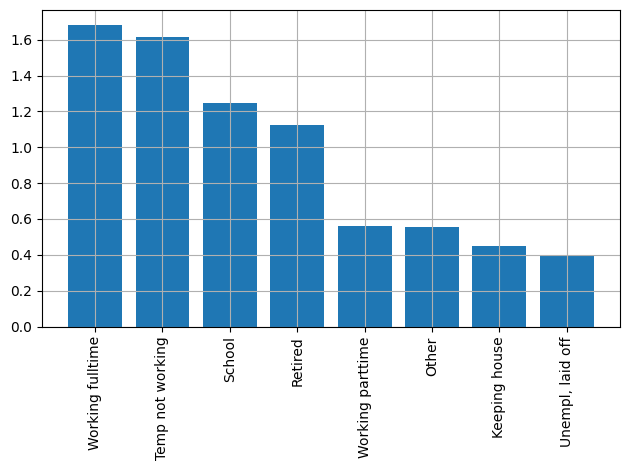

In [84]:
# Sắp xếp theo giá trị tuyệt đối của hệ số intercept, từ lớn đến nhỏ
sorted_indices = np.argsort(np.abs(model.intercept_))[::-1]

# Chuyển chỉ số sang tên lớp (pseudo-label)
sorted_labels = [index_to_pseudo_label[i] for i in sorted_indices]

# Lấy giá trị intercept tương ứng và làm tròn
sorted_values = np.round(model.intercept_[sorted_indices], 3)

# Tạo dictionary tên lớp và giá trị tương ứng
importance_intercept = dict(zip(sorted_labels, sorted_values))

# Vẽ biểu đồ
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid(True)
plt.title("")
plt.tight_layout()
plt.show()
